In [1]:
%matplotlib inline

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras import backend as K

import os
import shutil
import numpy as np

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# Loading data

In [3]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# One-hot encoding

In [4]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Running the neural network

In [5]:
dir = '/home/ricardo/mestrado/models/'
if os.path.exists(dir):
    shutil.rmtree(dir)
os.mkdir(dir)

In [6]:
%%time

nodes = 4096

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(nodes, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

save_model_checkpoint = ModelCheckpoint(dir + 'weights.{epoch:04d}-{val_loss:.5f}-{val_acc:.5f}.hdf5',
                                            verbose=0, 
                                            save_best_only=False,                                           
                                            save_weights_only=False,
                                            mode='auto',                                           
                                            period=1)
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[save_model_checkpoint],
                    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 23s 385us/step - loss: 0.1920 - acc: 0.9413 - val_loss: 0.0531 - val_acc: 0.9831
Epoch 2/12
60000/60000 [==============================] - 22s 359us/step - loss: 0.0516 - acc: 0.9843 - val_loss: 0.0401 - val_acc: 0.9866
Epoch 3/12
60000/60000 [==============================] - 22s 364us/step - loss: 0.0366 - acc: 0.9881 - val_loss: 0.0298 - val_acc: 0.9901
Epoch 4/12
60000/60000 [==============================] - 21s 356us/step - loss: 0.0261 - acc: 0.9919 - val_loss: 0.0258 - val_acc: 0.9914
Epoch 5/12
60000/60000 [==============================] - 22s 360us/step - loss: 0.0212 - acc: 0.9929 - val_loss: 0.0258 - val_acc: 0.9912
Epoch 6/12
60000/60000 [==============================] - 21s 358us/step - loss: 0.0164 - acc: 0.9948 - val_loss: 0.0293 - val_acc: 0.9918
Epoch 7/12
60000/60000 [==============================] - 21s 356us/step - loss: 0.0145 - acc: 0.9953 - val_loss: 0.

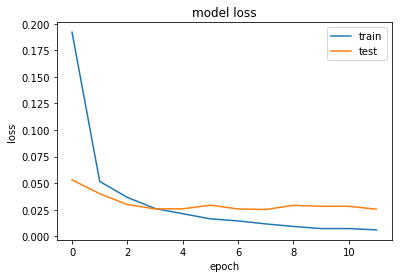

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

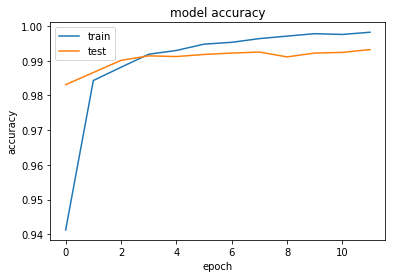

In [8]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# Analyzing the weights

In [9]:
m = model

def output_data(layer):
    print('min :', np.min(layer))
    print('std-:', np.average(layer)-np.std(layer))
    print('avg :', np.average(layer))
    print('std+:', np.average(layer)+np.std(layer))
    print('max :', np.max(layer))
    print()
    
def get_weight_bias(model, i):
    w = model.layers[i].get_weights()
    return w[0], w[1]

def process_epoch(n):    
    files = sorted(os.listdir(dir))    
    filename = dir+files[n]
    m.load_weights(filename)
    
    conv1w, conv1b = get_weight_bias(m, 0)
    conv2w, conv2b = get_weight_bias(m, 1)
    dense1w, dense1b = get_weight_bias(m, 5)
    dense2w, dense2b = get_weight_bias(m, 7)    

    return {
        'conv1w': conv1w,
        'conv1b': conv1b,
        'conv2w': conv2w,
        'conv2b': conv2b,
        'dense1w': dense1w,
        'dense1b': dense1b,
        'dense2w': dense2w,
        'dense2b': dense2b
    }

a = process_epoch(0)

In [10]:
labels = [
    'conv1w',
    'conv1b',
    'conv2w',
    'conv2b',
    'dense1w',
    'dense1b',
    'dense2w',
    'dense2b'
]

# Euclidean distance

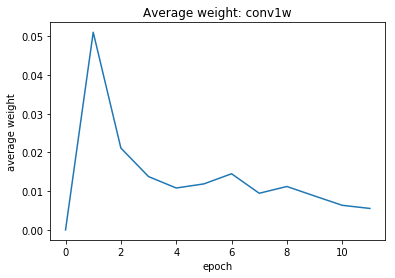

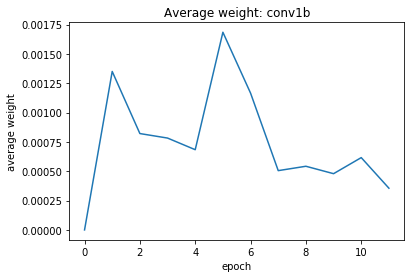

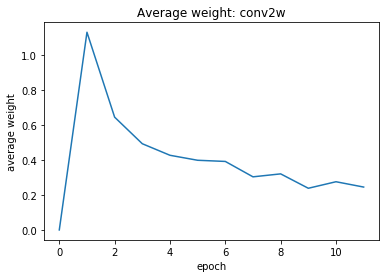

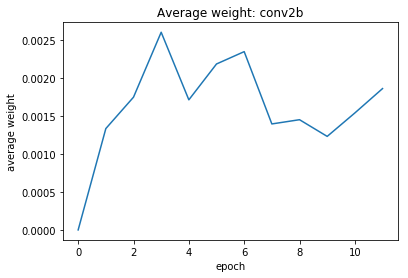

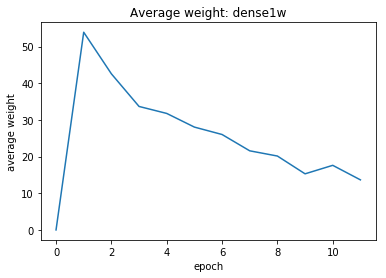

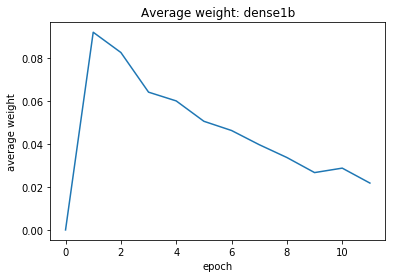

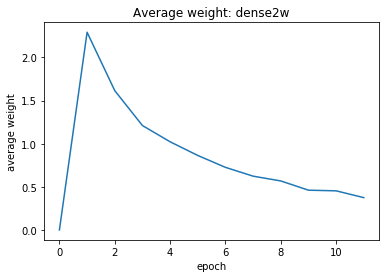

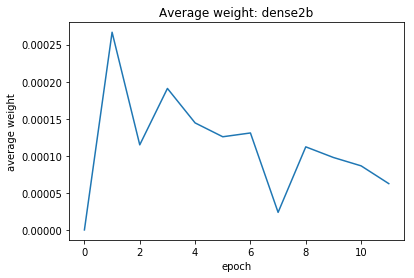

In [11]:
for l in labels:
    data = [0]
    plt.title('Average weight: ' + l)
    plt.ylabel('average weight')
    plt.xlabel('epoch')    
    for i in range(epochs-1):
        a = process_epoch(i)
        b = process_epoch(i+1)
        data.append(np.sum((a[l] - b[l]) ** 2))
    plt.plot(data)
    plt.show()

# Soma do valor absoluto

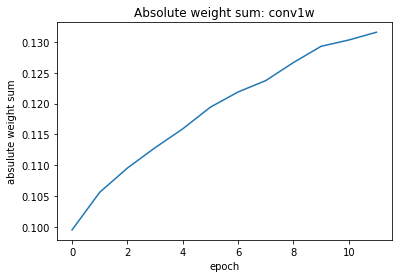

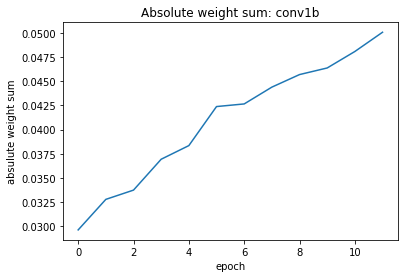

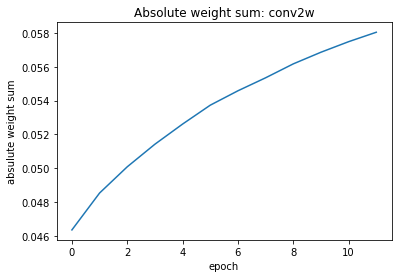

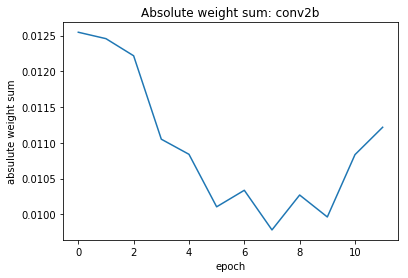

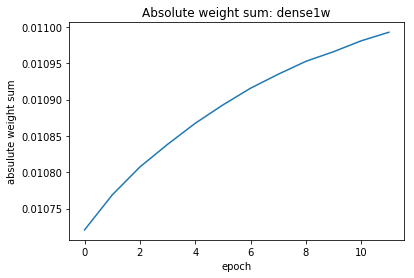

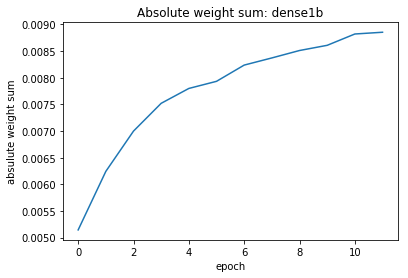

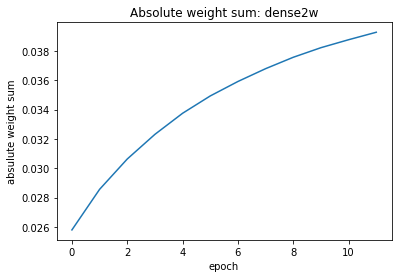

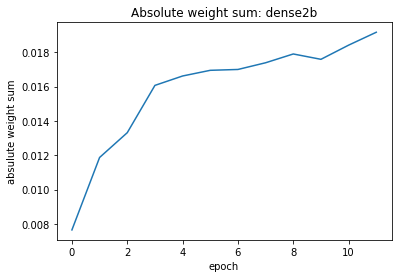

In [12]:
for l in labels:
    data = []
    plt.title('Absolute weight sum: ' + l)
    plt.ylabel('absulute weight sum')
    plt.xlabel('epoch')
    for i in range(epochs):
        a = process_epoch(i)        
        data.append(np.average(np.abs(a[l])))
    plt.plot(data)
    plt.show()

# Average 


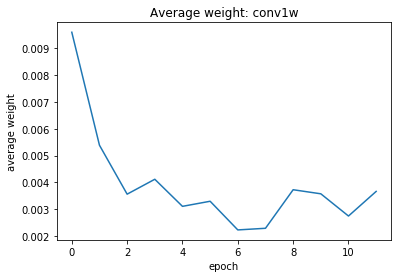

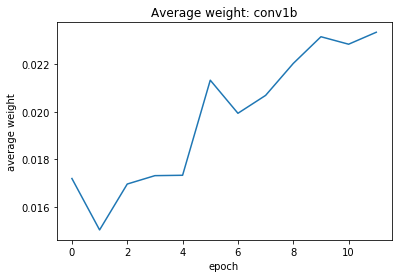

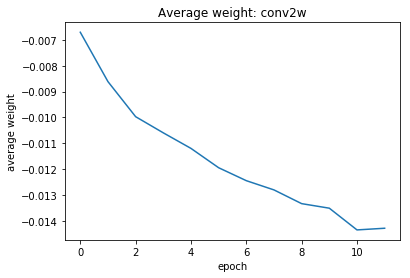

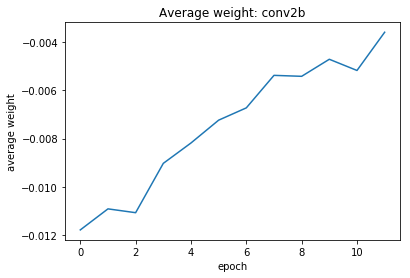

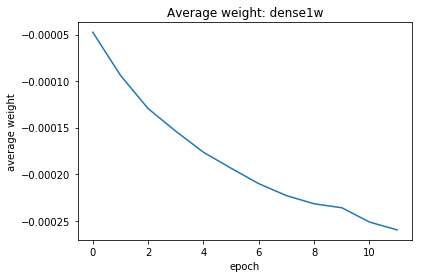

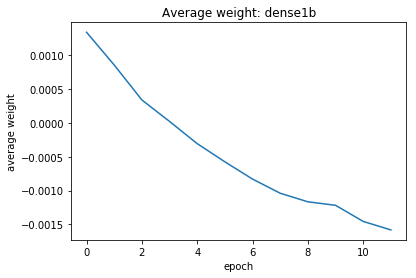

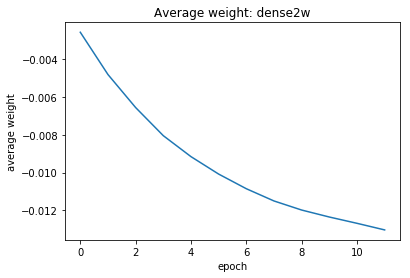

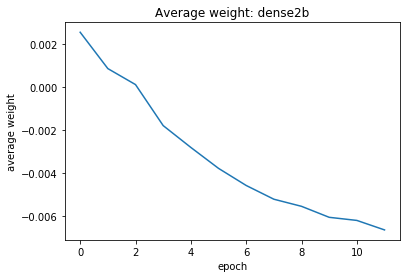

In [13]:
for l in labels:
    data = []
    plt.title('Average weight: ' + l)
    plt.ylabel('average weight')
    plt.xlabel('epoch')
    for i in range(epochs):
        a = process_epoch(i)        
        data.append(np.average(a[l]))
    plt.plot(data)
    plt.show()

# Count zeroes

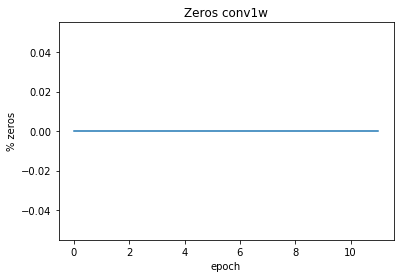

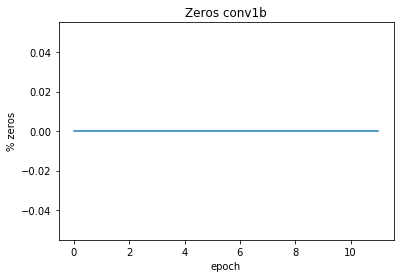

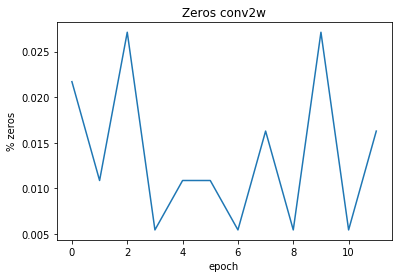

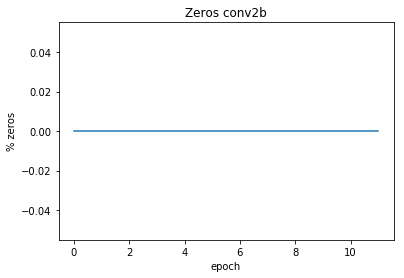

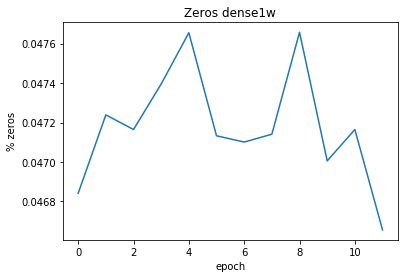

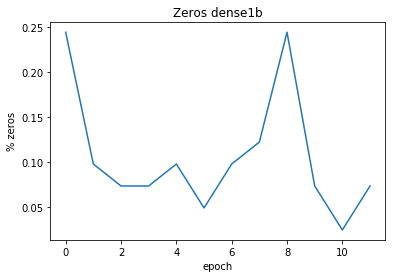

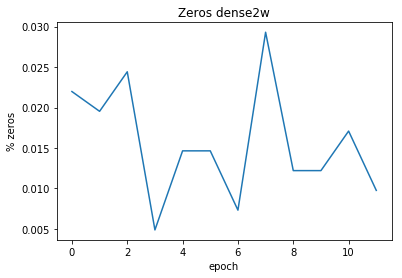

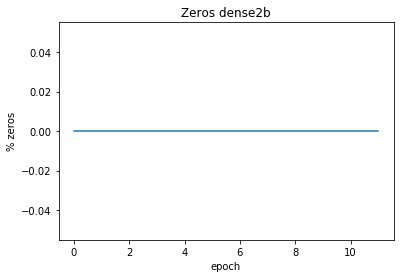

In [14]:
def count_zero_value(l, delta=1e-5):
    l = np.array(l).flatten()
    n = l.shape[0]
    return 100 * np.sum(np.abs(l) < delta) / float(n)


for l in labels:
    data = []
    plt.title('Zeros ' + l)
    plt.ylabel('% zeros')
    plt.xlabel('epoch')
    for i in range(epochs):
        a = process_epoch(i)        
        data.append(count_zero_value(a[l]))
    plt.plot(data)
    plt.show()

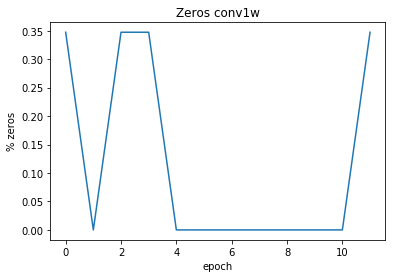

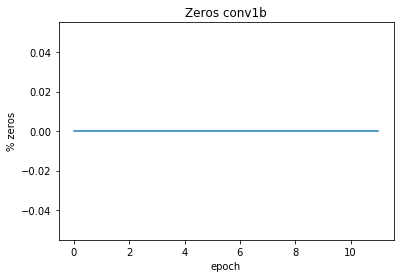

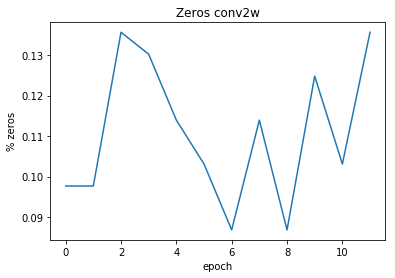

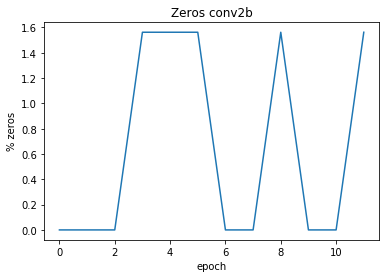

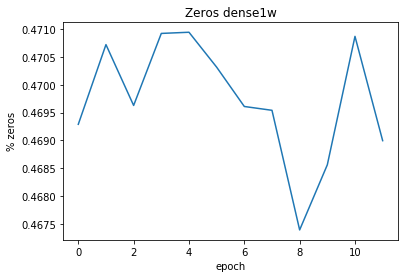

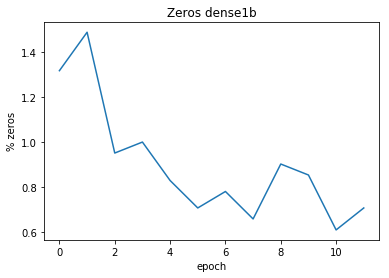

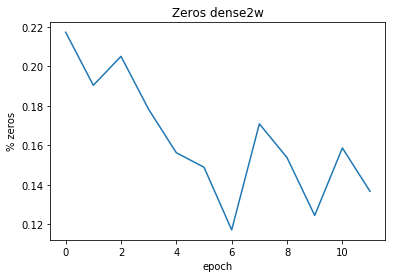

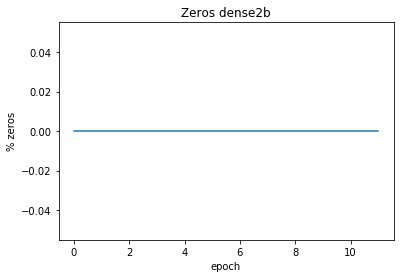

In [15]:
def count_zero_value(l, delta=1e-4):
    l = np.array(l).flatten()
    n = l.shape[0]
    return 100 * np.sum(np.abs(l) < delta) / float(n)


for l in labels:
    data = []
    plt.title('Zeros ' + l)
    plt.ylabel('% zeros')
    plt.xlabel('epoch')
    for i in range(epochs):
        a = process_epoch(i)        
        data.append(count_zero_value(a[l]))
    plt.plot(data)
    plt.show()

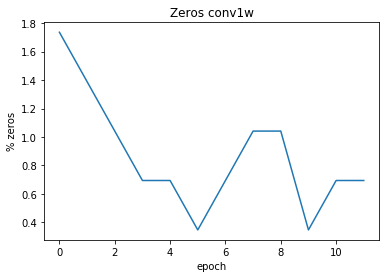

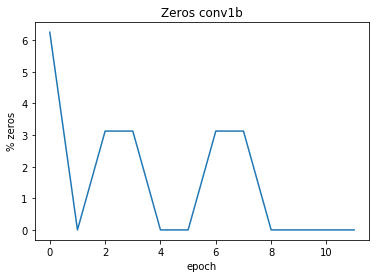

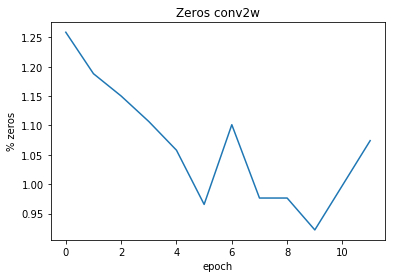

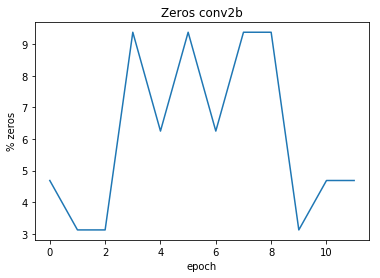

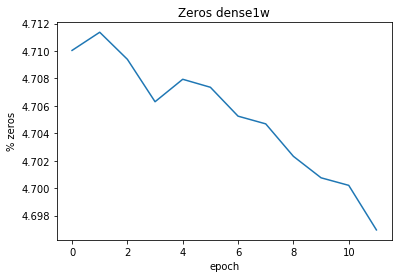

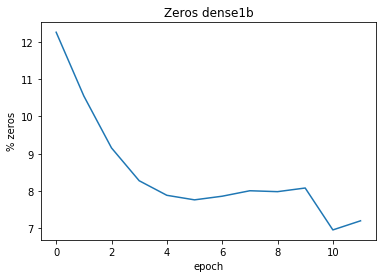

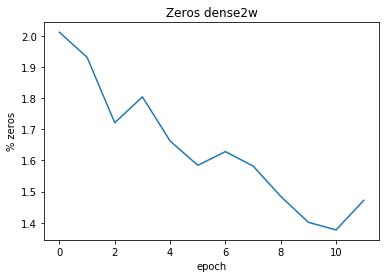

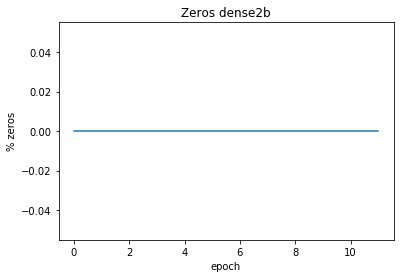

In [16]:
def count_zero_value(l, delta=1e-3):
    l = np.array(l).flatten()
    n = l.shape[0]
    return 100 * np.sum(np.abs(l) < delta) / float(n)


for l in labels:
    data = []
    plt.title('Zeros ' + l)
    plt.ylabel('% zeros')
    plt.xlabel('epoch')
    for i in range(epochs):
        a = process_epoch(i)        
        data.append(count_zero_value(a[l]))
    plt.plot(data)
    plt.show()

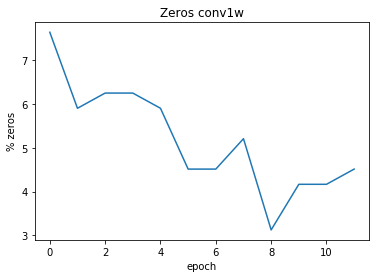

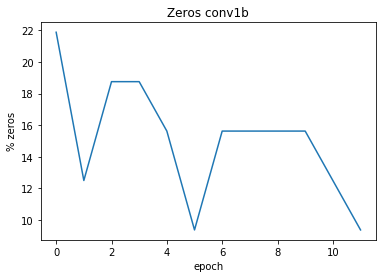

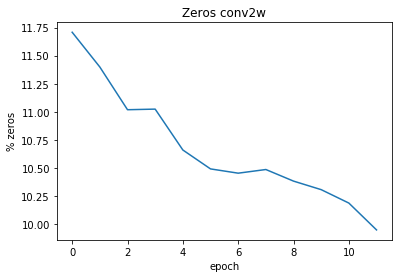

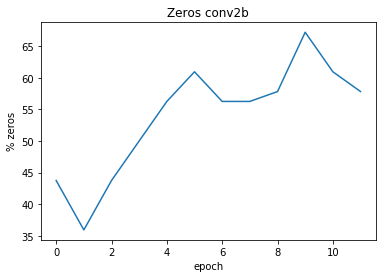

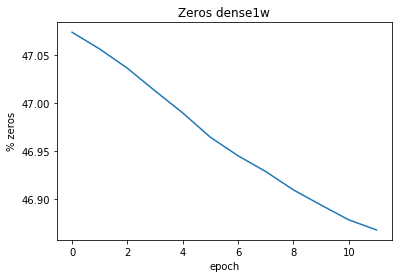

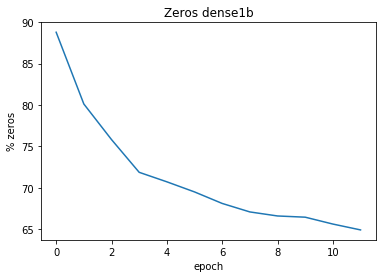

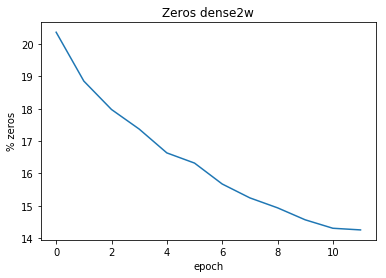

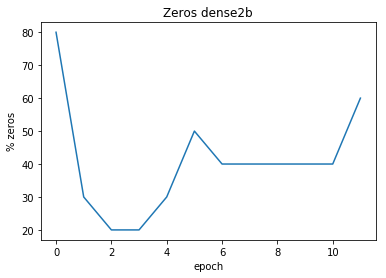

In [17]:
def count_zero_value(l, delta=1e-2):
    l = np.array(l).flatten()
    n = l.shape[0]
    return 100 * np.sum(np.abs(l) < delta) / float(n)


for l in labels:
    data = []
    plt.title('Zeros ' + l)
    plt.ylabel('% zeros')
    plt.xlabel('epoch')
    for i in range(epochs):
        a = process_epoch(i)        
        data.append(count_zero_value(a[l]))
    plt.plot(data)
    plt.show()